# Data Information

### Attribute information:

Input variables:
- age (numeric)
- job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
- marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
- education (categorical: "unknown","secondary","primary","tertiary")
- default: has credit in default? (binary: "yes","no")
- balance: average yearly balance, in euros (numeric) 
- housing: has housing loan? (binary: "yes","no")
- loan: has personal loan? (binary: "yes","no")
- contact: contact communication type (categorical: "unknown","telephone","cellular")
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
   
Output variable (desired target):
- y: has the client subscribed a term deposit? (binary: "yes","no")

# Importing Libraries and Dataset

In [16]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("processed-data.csv")

# Preprocessing

### Converting to categorical

In [3]:
# Converting all object variables to categorical variables

cols = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'poutcome', 'y']

for col in cols:
    df[col] = df[col].astype('category')

### Changing y to binary

In [4]:
# changing y to binary - 0 and 1
ymap = {'no': 0, 'yes': 1}

df.replace({'y':ymap}, inplace = True)

### Dummy variables

In [5]:
X = df.drop(['y'], axis=1)
y = df['y']

X = pd.get_dummies(X, columns=['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'poutcome'], drop_first=True)

### Splitting the dataset

In [6]:
#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 1, stratify=y)

In [7]:
y_train.value_counts(1)

0    0.883022
1    0.116978
Name: y, dtype: float64

In [8]:
y_test.value_counts(1)

0    0.882999
1    0.117001
Name: y, dtype: float64

# Model Evaluation Criteria

#### The incorrect predictions are the following:
- Customer predicted to buy, but actually doesn't buy (Type I).
- Customer predicted to not buy, but actually buys (Type II).
<br><br>
The more costly error is the type II error, as the bank would not market the product to this customer, and fail to make a sale because the customer would have in reality bought the product.<br><br>
Type I errors will make the bank focus on customers that would not buy the product, so it is not too much of a cost except for the time and effort put into these customers.

#### Therefore, we will need to identify as much potential customers as possible, so recall will be the ideal metric to use for evaluation.

#### Note: I will be using 0.05 as the value of alpha

### Creating functions to calculate metrics

In [9]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,train,test,train_y,test_y,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    pred_train = np.round(pred_train)
    pred_test = np.round(pred_test)
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
   # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
    return score_list # returning the list with train and test scores

In [10]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Tuned XG Boost

In [11]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": np.arange(10,80,20),
    "scale_pos_weight":[0,1,2,5],
    "subsample":[0.5,0.7,0.9,1],
    "learning_rate":[0.01,0.1,0.2,0.05],
    "gamma":[0,1,3],
    "colsample_bytree":[0.5,0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,0.9,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(xgb_tuned, parameters,scoring=scorer, random_state=9)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=70, n_jobs=4,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=5, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

#### This is a fantastic result in terms of recall. The recall has drastically improved to 0.81 on test set. The precision is low at 0.46, but it is affordable since the main aim is to maximise sales, so if some effort is wasted on customers that will not buy, that is ok.

### Metrics

Accuracy on training set :  0.8914273074857016
Accuracy on test set :  0.8797552344441167
Recall on training set :  0.8860075634792004
Recall on test set :  0.8254568367989918
Precision on training set :  0.521131236097871
Precision on test set :  0.49174174174174173


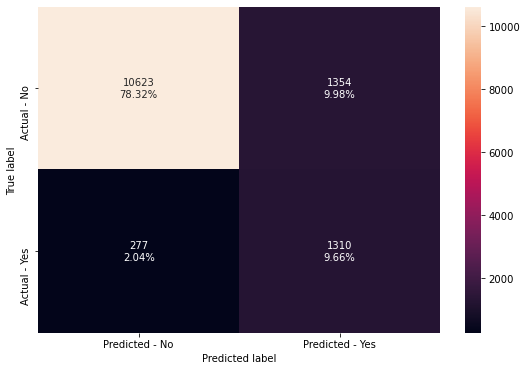

In [17]:
metric_xbc_tuned = get_metrics_score(xgb_tuned, X_train, X_test, y_train, y_test)
make_confusion_matrix(xgb_tuned,y_test)

#### Out of 1587 customers who bought the product, the model correctly identified 1310 customers, which is excellent. It also incorrectly identified 1354 other customers as potential buyers. This is not ideal, but considering the recall score and the number of correct buyers identified, this is totally fine.

### Feature Importance

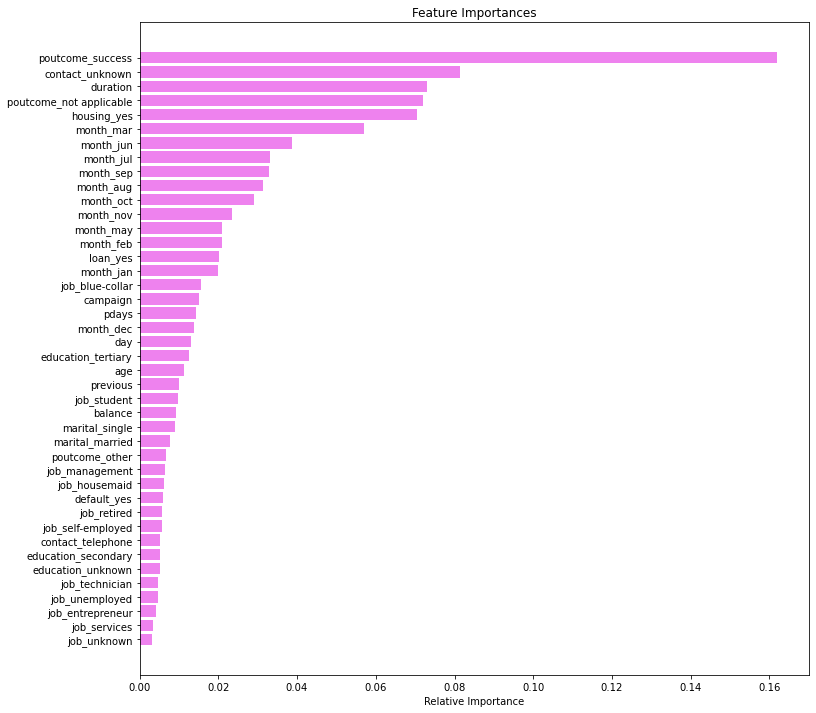

In [18]:
feature_names = X_train.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Observations
- As expected, the model considers the outcome of previous campaign as the most important. This was clear in the EDA, where more than 50% of previous buyers bought the term deposit as well. The only issue would be the lack of data since very few customers were actually contacted for a previous campaign.
- The second most important feature is contact_unknown, followed by duration which I am not too sure what the reason is.

# Conclusion

After running several models and tuning hyperparameters, the best model chosen was the tuned XG Boost model.

Some recommendations to the bank are:
- Generally focus on customers that previously bought a product from a campaign.
- Keep in mind that there will be a lot of customers recommended by the model who will not buy in reality, but the model will get as much potential buyers as possible.
- The model can be improved by getting better data, such as average call duration instead of the last one only, how long a customer has been with the bank, etc.
- It would also be useful to segment the customers into groups, and then products can be better tailored and marketed to the customers.